# Selection network architecture with genetics algorithm

This notebook is inspired by the following paper: [Efficient Architecture Search for Deep Neural Networks](https://www.sciencedirect.com/science/article/pii/S1877050920303859)

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import copy
from collections import OrderedDict
from scripts import utils

%load_ext autoreload
%autoreload 2

### Import dataset

In [3]:
from scripts import cifar10
trainloader, testloader, classes = cifar10.cifar10()

Files already downloaded and verified
Files already downloaded and verified


### Define basic network

In [51]:
utils.compute_output_conv2d((32,32), kernel_size=(3,3), padding=(1,1), stride=(1,1), dilation=(1,1))

(32, 32)

In [18]:

utils.compute_output_conv2d(32, kernel_size=1, padding=0, stride=1, dilation=1)

32

In [4]:
class _Chromotype():
    def __init__(self, num_layers, num_input, num_output, inerithance=None):
        self.num_layers = num_layers   # numero di layer che dipendono dal cromosoma (in questo caso per ogni blocco denso:)
        self.num_input = num_input     # size of the input features (channels)
        self.num_output = num_output  # size of the output features (channels)
        

        #define chromosome types
        # questi sono i layer che possono essere usati 
        self.lchromosomes = [
                            nn.Conv2d(num_input, num_output, kernel_size=1, padding=0),
                            nn.Conv2d(num_input, num_output,
                                           kernel_size=3, stride=1, padding=1,
                                           bias=False),
                            nn.Conv2d(num_input, num_output,
                                           kernel_size=5, stride=1, padding=2 ,groups=2,
                                           bias=False),
                            nn.Conv2d(num_input, num_output,
                                           kernel_size=7, stride=1, padding=3 ,groups=2,
                                           bias=False),
                            nn.Conv2d(num_input, num_output,
                                            kernel_size=3, stride=1, padding=1 ,groups=2,  dilation=1,
                                            bias=False)
                            ]
        self.number_of_genes = len(self.lchromosomes) # numero di possibili layer per chromosome

        # inizializzazione della configurazione.
        #  Il parametro inerithance serve (in futuro) per inizializzare la configurazione a partire da una configurazione precedente                    
        if(inerithance is None):
            self.config = []
            for i in range(self.num_layers):        # inizializza randomicamente la configurazione
                self.config.append(np.random.randint(0, self.number_of_genes))
            self.config = np.array(self.config)
            
    def get_chromotype(self, el):    # restituisce il layer corrispondente al gene
        if el>= self.number_of_genes:
            raise ValueError("chromosome index out of range")
        return self.lchromosomes[el]
    


La rete è composta da 4 blocchi densi, ognuno composto da 3 layer densi. Tra i blocchi vi è un layer di transizione.

input--- > __[layer1 --> layer2 --> layer3]__ --> trans_layer1 --> __[layer1 --> layer2 --> layer3]__ --> trans_layer2 --> __[layer1 --> layer2 --> layer3]__  --> trans_layer3 -->  __[layer1 --> layer2 --> layer3]__ --> flatten e MLP --> output (10 classi)

Un layer denso è così composto (___bottleneck___):

___BatchNorm --> Conv 1x1 --> ReLU___ --> BatchNorm --> Cromosoma --> Relu 


Ogni layer denso prende in input l'output del layer precedente e l'input del layer precedente (se esiste). Tutti gli input sono concatenati e passano attraverso il bottlenck per ridurre le dimensioni e tenerle costanti e poi passano nel "cuore" del layer.


In [6]:
class _Transition(nn.Sequential): # layer di transizione tra due blocchi densi
    def __init__(self, num_input_features, num_output_features):
        super(_Transition, self).__init__()
        self.add_module('BN', nn.BatchNorm2d(num_input_features))
        self.add_module('1x1', nn.Conv2d(num_input_features, num_output_features,
                                          kernel_size=1, stride=1, bias=False))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2))



    
#define dense layer and bottleneck layer
class _DenseLayer(nn.Module): 
    def __init__(self,chromosome, num_input_features, growth_rate, bn_size, drop_rate, memory_efficient=False):
        print(chromosome)
        super(_DenseLayer, self).__init__()
        self.add_module('BN_1', nn.BatchNorm2d(num_input_features))
        self.add_module('conv1', nn.Conv2d(num_input_features, bn_size *
                                           growth_rate, kernel_size=1, stride=1,
                                           bias=False))
        self.add_module('relu_1', nn.ReLU(inplace=True))
        self.add_module('BN_2', nn.BatchNorm2d(bn_size * growth_rate))
        self.add_module('chromo', chromosome) # questo è il cromosoma, il layer viene passato come parametro dal blocco denso corrispondente
        self.add_module('relu_2', nn.ReLU(inplace=True))
        self.drop_rate = float(drop_rate)
        self.memory_efficient = memory_efficient

    def bn_function(self, inputs):      
        "Bottleneck function"
        # type: (List[Tensor]) -> Tensor
        concated_features = torch.cat(inputs, 1)
        bottleneck_output = self.relu_1(self.conv1(self.BN_1(concated_features)))  # noqa: T484
        return bottleneck_output

    def forward(self, input):  # noqa: F811
        if torch.is_tensor(input):
            prev_features = [input]
        else:
            prev_features = input

        bottleneck_output = self.bn_function(prev_features)
        new_features = self.relu_2(self.chromo(self.BN_2(bottleneck_output)))
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate,
                                     training=self.training)
        return new_features



class _DenseBlock(nn.ModuleDict):
    _version = 2

    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate, memory_efficient=False, chromoconfig=None):
        super(_DenseBlock, self).__init__()

        self.chromosome = _Chromotype(num_layers, bn_size*growth_rate, growth_rate, inerithance=None) # ogni blocco ha una configurazione per i layer
        print("configurazione blocco denso:", self.chromosome.config)


        for i in range(num_layers):
            layer = _DenseLayer(        # il blocco denso è composto da num_layers layer, ogni layer ha un cromosoma diverso 
                self.chromosome.get_chromotype(self.chromosome.config[i]),
                num_input_features + i * growth_rate,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient,
            )
            self.add_module('denselayer%d' % (i + 1), layer)

    def forward(self, init_features):
        features = [init_features]
        for name, layer in self.items():
            new_features = layer(features)
            features.append(new_features)
        return torch.cat(features, 1)

class DenseNet(nn.Module):
    def __init__(self, growth_rate=32, block_config=(3, 3, 3, 3),           #4 blocchi da 3 layer ciascuno
                 num_init_features=64, bn_size=4, drop_rate=0, num_classes=10, memory_efficient=False):

        super(DenseNet, self).__init__()

        # layer iniziali prima del primo blocco denso:
        # self.features = nn.Sequential(OrderedDict([
        #     ('conv0', nn.Conv2d(3, num_init_features, kernel_size=7, stride=2,
        #                         padding=3, bias=False)),
        #     ('norm0', nn.BatchNorm2d(num_init_features)),
        #     ('relu0', nn.ReLU(inplace=True)),
        #     ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
        # ]))


        self.features = nn.Sequential()  
        
        
        
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient
            )
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                # add transition layer between denseblocks to 
                # downsample
                trans = _Transition(num_input_features=num_features,
                                    num_output_features=num_features // 2)
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2

        # Final batch norm
        self.features.add_module('norm5', nn.BatchNorm2d(num_features))

        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)

        # Official init from torch repo.
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out


net = DenseNet()

configurazione blocco denso: [3 2 3]
Conv2d(128, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=2, bias=False)
Conv2d(128, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=2, bias=False)
Conv2d(128, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=2, bias=False)
configurazione blocco denso: [3 1 4]
Conv2d(128, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=2, bias=False)
Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2, bias=False)
configurazione blocco denso: [0 1 2]
Conv2d(128, 32, kernel_size=(1, 1), stride=(1, 1))
Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(128, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=2, bias=False)
configurazione blocco denso: [1 3 0]
Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(128, 32, kernel_size=(7

Test the network:

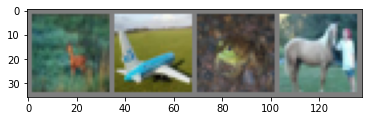

torch.Size([4, 10])


In [8]:
images , classes = next(iter(trainloader))

def imgshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imgshow(torchvision.utils.make_grid(images))

print(net(images).shape)